# Prédiction de l'âge d'un sujet à partir de son activité cérébrale
**Auteurs:** Simon Aubenau & Thomas Levy (03/01/2018)
    
Ce notebook décrit notre projet Python qui traite le chalenge sur la 
"Prédiction de l'âge d'un sujet à partir de son activité cérébrale" qui est accessible sur le site Challenge Data:
 [Challenge Prediction de lage](https://challengedata.ens.fr/fr/challenge/19/prediction_de_lage_dun_sujet_a_partir_de_son_activite_cerebrale.html)   



## Introduction
Le but de ce challenge est de prédire l'âge d'un sujet à partir de son activité cérébrale pendant les differentes phases de son sommeil nocturne.

Il est proposé par la société Rythm qui developpe un bandeau connecté [Dreem](https://dreem.com/fr/) qui permet de mesurer l'activité cérébrale pendant le sommeil et vise à améliorer la qualité du sommeil par des stimulations.

## Contexte
Le suivi de l'activité cérébrale présente un grand intérêt pour étudier le sommeil et les maladies du sommeil. 
Les médecins du sommeil distinguent différents stades de sommeil à partir de caractéristiques temporelles et fréquentielles observées notamment dans les électroencéphalogrammes (EEG). 
Ils ont élaboré des règles d'identification afin d'associer à chaquer échantillon de 30s de nuit de sommeil un stade de sommeil particulier : Wake, Rapid Eye Movement (REM), N1 (Non REM1), N2 (Non REM2), N3 (Non REM3 qui correspond au sommeil profond), REM (aussi appelé sommeil paradoxal). 
Ainsi peut-on associer à une nuit de sommeil, un enchainement de stades de sommeil appelé "hypnogramme".

Nous cherchons à prédire l'âge d'un sujet à partir :
* (a) de 5 minutes d'un enregistrement EEG, pendant le sommeil profond
* (b) de l'hypnogramme associé à la nuit en question

La mesure de performance utilisée pour ce challenge est la Mean Average Percentage Error (MAPE)

## Données disponibles
Les fichiers qui nous sont fournis sont:
* fichier input d'entrainement
* fichier output d'entrainement
* fichier input de test


## Import des librairies & lecture des données

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor

############################
## OUVERTURE DATA FRAMES
############################

df = pd.read_csv("train_input.csv", sep=";", encoding="utf8", low_memory=False)
dfY = pd.read_csv("train_Y.csv", sep=";", encoding="utf8", low_memory=False)

df['Age']=dfY.TARGET

In [3]:
df.head(5)

,ID,DEVICE,EEG_0,EEG_1,EEG_2,EEG_3,EEG_4,EEG_5,EEG_6,EEG_7,...,EEG_74992,EEG_74993,EEG_74994,EEG_74995,EEG_74996,EEG_74997,EEG_74998,EEG_74999,HYPNOGRAM,Age
0,0,0.0,18.513157,17.887674,17.442404,16.944677,16.080168,15.002975,13.949936,13.029482,...,-11.230370,-11.445168,-11.626509,-11.631254,-11.295610,-10.671482,-9.810492,-9.003139,"['0', '0', '0', '0', '0', '0', '0', '0', '0', ...",32
1,1,0.0,3.377115,3.720635,4.122524,4.086743,3.476264,2.501397,1.601755,0.721100,...,-7.700051,-5.312872,-2.887947,-1.066923,0.143711,1.566658,3.194142,4.335758,"['0', '0', '0', '0', '0', '0', '2', '0', '0', ...",29
2,2,0.0,20.753752,33.122223,41.263256,44.764065,45.441994,44.729267,42.983265,40.561638,...,0.194748,-1.819428,-3.309473,-4.242142,-4.506508,-4.677623,-4.937207,-4.994258,"['0', '0', '0', '0', '0', '0', '0', '0', '0', ...",36
3,3,0.0,14.535362,14.571295,14.288245,13.808476,13.219709,12.498644,11.697461,10.954629,...,3.678608,3.307606,3.170362,3.239853,3.253531,3.081603,2.759164,2.302796,"['0', '0', '0', '0', '0', '0', '0', '0', '0', ...",56
4,4,1.0,0.000006,0.000006,0.000006,0.000009,0.000008,0.000011,0.000009,0.000010,...,0.000032,0.000027,0.000025,0.000022,0.000021,0.000019,0.000019,0.000022,"['0', '0', '0', '0', '0', '0', '0', '0', '0', ...",60


Les données sont donc constitutées des colonnes suivantes :
* Une colonne DEVICE qui correspond à l'appareil utilisé pour la mesure de l'eeg. (valeur 0 ou 1)
* 75000 colonnes EEG_0 à EEG_74999 qui correspondent à l'eeg. (valeurs continues)
* Une colonne HYPNOGRAM, c'est une suite numérique de taille variable, et prenant des valeurs discrètes entre -1 et 4.
* Une colonne AGE, que nous devrons réussir à prédire.

Telles quelles, ces données ne sont pas utilisables pour l'apprentissage.

### Affichage de l'hypnogramme
On affiche l'hypnogramme pour 2 individus d'âge différent

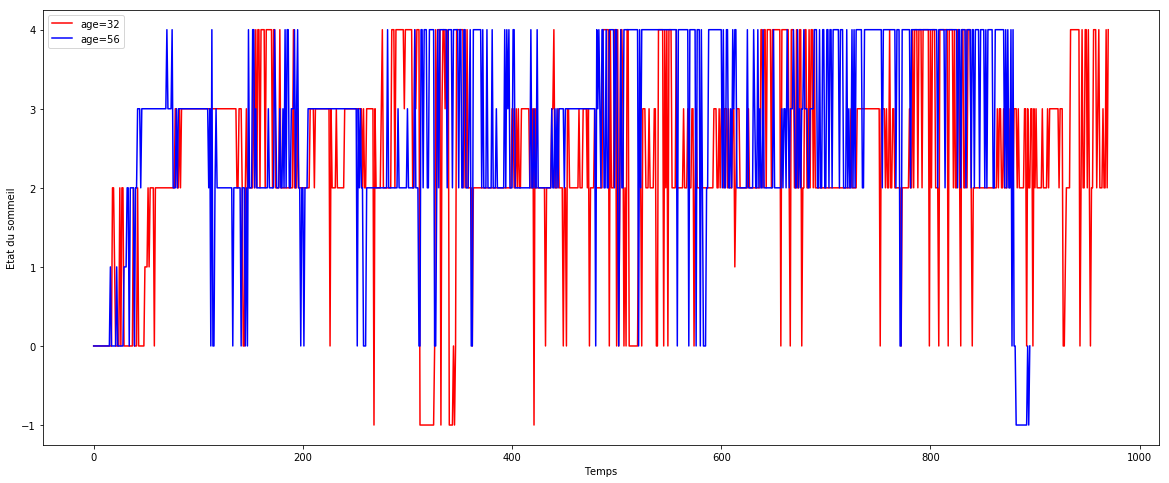

In [4]:
import matplotlib.pyplot as plt

str1 = df.HYPNOGRAM[0]
str2 = df.HYPNOGRAM[3]
list = str1.split(",")
list2 = str2.split(",")
for idx in range(len(list)):
    list[idx]= list[idx].strip('[').strip(']').strip(" ").strip("'")
for idx in range(len(list2)):    
    list2[idx]= list2[idx].strip('[').strip(']').strip(" ").strip("'")    
tseries1 = pd.Series(list,dtype=int)
tseries2 = pd.Series(list2,dtype=int)
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(tseries1,color='r',label='age=32')
ax1.plot(tseries2,color='b',label='age=56')
#ax1.set_xlim([0,700])
ax1.set_ylabel('Etat du sommeil')
ax1.set_xlabel('Temps')
ax1.legend(loc='best')
plt.show()

La taille de l'hypnogramme dépend de la durée de la nuit de l'individu, et peut donc varier. Les valeurs correspondent à la phase de sommeil dans laquelle se trouve l'individu. Elle prend la valeur 0 lors d'un micro-réveil de l'individu. Les valeurs -1 correspondent à des erreurs lors des mesures, elles seront donc ignorées par la suite.

### Affichage de l'EEG
On affiche l'EEG pour 2 individus d'âge différent

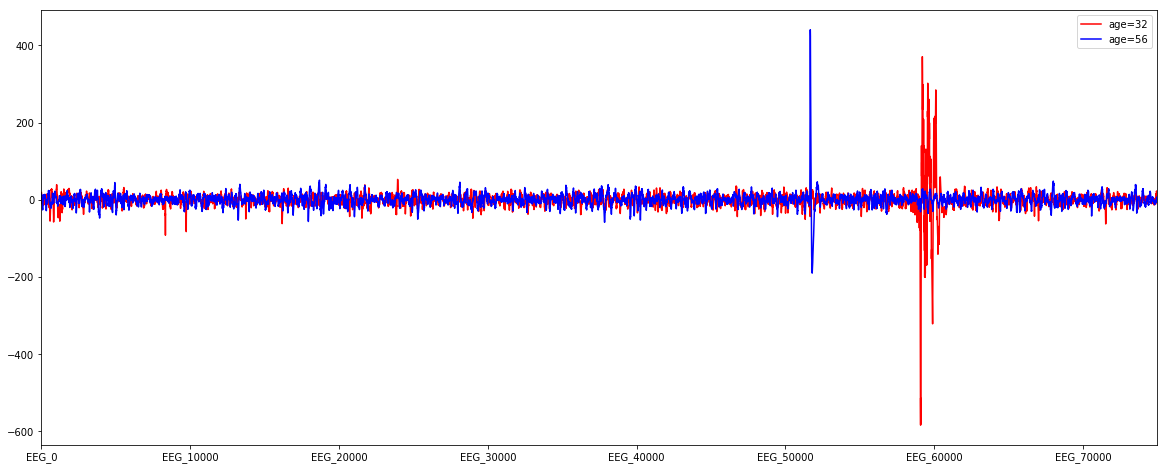

In [10]:
eeg = df.select_dtypes(include=[int,float])
eeg = eeg.drop("DEVICE",axis=1)

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,1,1)
tseries1 = pd.Series(eeg.iloc[0])
tseries2 = pd.Series(eeg.iloc[3])
tseries1.plot(color='r',label='age=32')
tseries2.plot(color='b',label='age=56')
ax1.legend(loc='best')
plt.show()

Pour mieux comprendre, voici un zoom des deux courbes précédentes pour les 2500 premières valeurs :

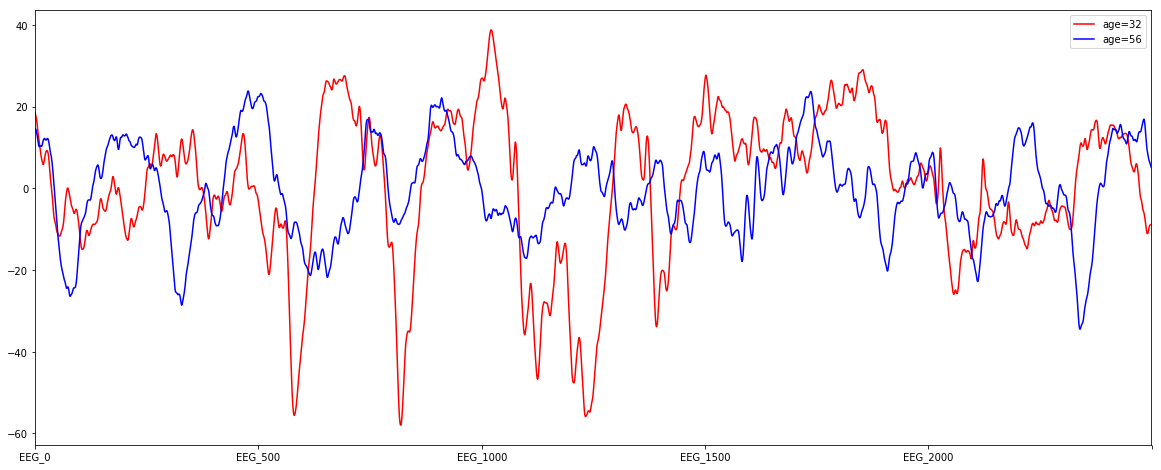

In [11]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,1,1)
tseries1 = pd.Series(eeg.iloc[0])
tseries2 = pd.Series(eeg.iloc[3])
idx = np.array(range(0,2500))
tseries1[idx].plot(color='r',label='age=32')
tseries2[idx].plot(color='b',label='age=56')
ax1.legend(loc='best')
plt.show()

## Premiere analyse
Les données qui nous sont fournies sont des séries temporelles qu'on ne peut pas utiliser telles quelles pour faire de la prédiction.
Nous allons donc essayer d'extraire des données pertinentes afin de pouvoir faire de l'apprentissage.

### Autocorrélation de l'eeg
L'eeg est mesurée pendant 5 minutes de sommeil profond. Puisque cette mesure peut être prise n'importe quand pendant la nuit, nous la traitons comme une série temporelle stationnaire.

Nous calculons donc à la courbe d'autocorrélation associée à l'eeg.   

In [12]:
eeg = df.select_dtypes(include=[int,float])
eeg = eeg.drop("DEVICE",axis=1)

# transposed_eeg est plus pratique a manipuler
transposed_eeg = eeg.transpose()

# les eeg sont mesurées par deux appareils 'DEVICE' différents
# les ordres de grandeur des courbes sont complètements différents 
# en fonction du DEVICE utilise
#
# on modifie donc les eeg de façon à ce que 
#    la moyenne de chaque courbe soit égale à 0
#    la 'variance' de chaque courbe soit égale à 1
normalised_eeg = transposed_eeg
for i in range(0, 581):
    vect = transposed_eeg[i]
    mean = np.mean(vect)
    variance = np.var(vect)
    normalised_vect = (vect-mean)/math.sqrt(variance)
    normalised_eeg[i] = normalised_vect

Comme le calcul est long, nous stockons le résultat dans un fichier,
pour pouvoir le réutiliser par la suite.

In [28]:
def autocorrelation(x):
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    result = r/(variance*(np.arange(n, 0, -1)))
    return result[1:2000]

In [ ]:
# calcul des autocorrelations d'ordre 1 à 2000 pour les 581 patients.
autocorr = pd.DataFrame(0, index=np.arange(0, 1999), columns=[])
for i in range(0, 11):
    vect = normalised_eeg[i]
    ac = autocorrelation(vect)
    autocorr[str(i)]=ac
    #print('calcul autocorrelation: ', i, '/581')
    
# puisque ce calcul est long, nous stockons le résultat dans un fichier,
# pour pouvoir le réutiliser par la suite.
autocorr.to_csv("autocorr.csv", sep=";",index=False)

In [29]:
# par la suite, il suffira de lancer cette commande
autocorr = pd.read_csv("autocorr.csv", sep=";")

In [30]:
autocorr.head(5)

,0,1,2,3,4,5,6,7,8,9,...,571,572,573,574,575,576,577,578,579,580
0,0.997954,0.987110,0.998234,0.998957,0.996305,0.998317,0.991481,0.998638,0.998885,0.998489,...,0.990598,0.974261,0.998703,0.998893,0.998118,0.997242,0.998186,0.998522,0.999189,0.999703
1,0.992294,0.951737,0.993039,0.995922,0.989789,0.993445,0.968047,0.994655,0.995658,0.994114,...,0.964794,0.944205,0.994966,0.995786,0.992787,0.989224,0.992980,0.994227,0.996832,0.998835
2,0.984053,0.901719,0.984640,0.991059,0.979149,0.985717,0.934625,0.988268,0.990544,0.987183,...,0.928281,0.894191,0.989100,0.990971,0.984791,0.976508,0.984898,0.987397,0.993027,0.997398
3,0.974272,0.845719,0.973356,0.984591,0.965891,0.975596,0.896711,0.979777,0.983836,0.978098,...,0.887326,0.835253,0.981514,0.984805,0.975186,0.959896,0.974603,0.978418,0.987928,0.995418
4,0.963629,0.790573,0.959538,0.976739,0.950679,0.963572,0.858720,0.969493,0.975832,0.967269,...,0.846825,0.796940,0.972615,0.977594,0.965022,0.940290,0.962730,0.967694,0.981708,0.992920


### Affichage de l'autocorrélation

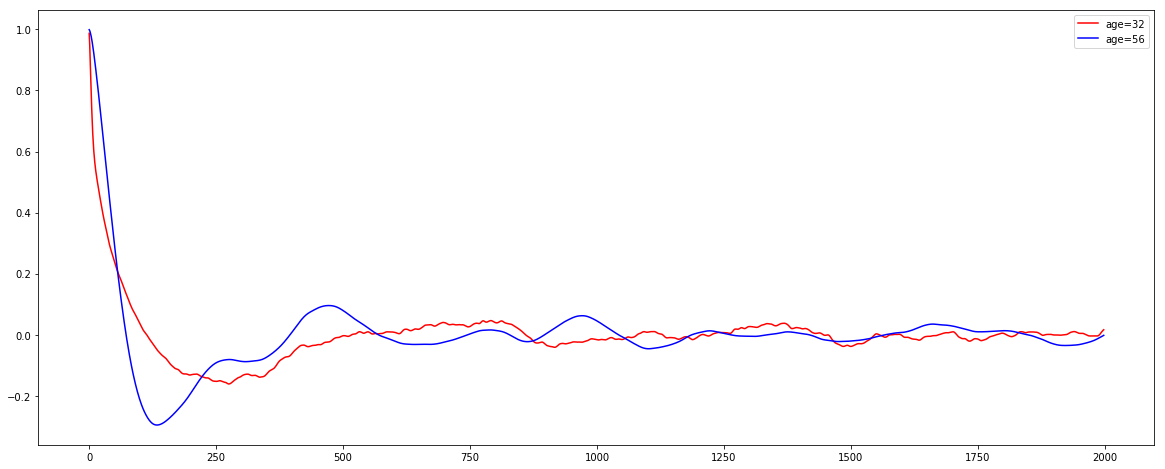

In [31]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,1,1)
plt.plot(autocorr['1'],color='r',label='age=32')
plt.plot(autocorr['3'],color='b',label='age=56')
ax1.legend(loc='best')
plt.show()

### Transformation en variables
De cette courbe d'autocorrélation, nous allons extraire des variables qui vont constituer les données d'entraînement de nos algorithmes. Nous extrayons donc des points qui nous semblent intéressants pour l'apprentissage :
* La position du minimum sur la courbe d'autocorrélation. Nous en extrayons l'abscisse et l'ordonnée.
* La position du second maximum ( le maximum global est situé en (0,1) par construction ). Encore une fois, nous utilisons son abscisse et son ordonnée.
* Nous utilisons aussi des valeurs régulièrement espacées de la courbe d'autocorrélation. Nous ne pouvons pas choisir trop de points, car cela augmente la dimension, mais nous voulons transmettre les informations présentes dans cette courbe à l'algorithme d'apprentissage. Nous avons donc choisi les autocorrélations d'ordre 50, 100, 150 ... jusqu'à 800. Cela fait 16 variables.

Nous utilisons aussi l'outil fourier fourni par numpy pour extraire les deux fréquences dominantes de l'eeg.


#### Partie hypnogramme
De même, nous devons extraire des valeurs de l'hypnogramme pour constituer les données d'entraînement. Nous calculons donc les variables suivantes :
* La durée totale de chaque phase du sommeil pendant la nuit (variables: n0,..)
* La durée totale du sommeil de l'individu (n+)
* Le nombre de passages en sommeil profond (nD)
* Le nombre de réveils (nW)
* Les nombres de transition entre chaque phase de sommeil (nX_Y nombre de transition de la phase X vers la phase Y)
* La durée moyenne passée de manière inintérrompue dans chaque phase de sommeil (variables: t0,..)
* La durée maximale passée de manière inintérrompue dans chaque phase de sommeil (variables: t0_max)

In [16]:
# Nous allons extraire un certain nombre de caracteristiques des hypnogrammes:

# calcul du nombre de réveils (nombre de passages à la phase 0)
def nWake(tseries):
    nWake = 0
    sleep = False
    for idx in range(len(tseries)):
        if (tseries[idx] > 0):
            sleep = True
        if (tseries[idx] == 0) & ( sleep== True):
            sleep = False
            nWake = nWake+1
    #print (nWake)
    return nWake

# calcul du nombre de fois ou le patient passe en sommeil profond
# (nombre de passages à la phase 4
def nDeep(tseries): #Nombre de 
    nDeep = 0
    deep = False
    for idx in range(len(tseries)):
        if (tseries[idx] == 4):
            deep = True
        if (tseries[idx] != 4) & ( deep== True):
            deep = False
            nDeep = nDeep+1
    return nDeep

# calcul du nombre de transitions d'une phase vers une autre.
# ( matrice de transition)
def count_transitions(tseries):
    transitions = np.zeros((5, 5))
    last = tseries[0]
    for idx in range(1, len(tseries)):
        if( tseries[idx] >= 0 ):
            new = tseries[idx]
            transitions[last,new] += 1
            last = new
    return transitions

# calcul de la durée moyenne passée dans chaque phase 
# avant de passer à une autre phase
def count_durations(tseries):
    durations = np.array([0, 0, 0, 0, 0], float)
    nb_periods = np.array([0, 0, 0, 0, 0], float)
    last = tseries[0]
    c = 1
    for idx in range(1, len(tseries)):
        if( tseries[idx] >= 0 ):
            if( tseries[idx] == last):
                c += 1
            else:
                durations[last]+=c
                nb_periods[last]+=1
                last = tseries[idx]
                c = 1
    durations[last]+=c
    nb_periods[last]+=1   
    for i in range(1, 5):
        if nb_periods[i]>0:
            durations[i]=durations[i]/nb_periods[i]
        else:
            durations[i]=0
    return durations

# calcul de la durée maximum passée dans chaque phase
# avant de passer à une autre phase
def count_durations_max(tseries):
    durations_max = np.array([0, 0, 0, 0, 0], float)
    last = tseries[0]
    c = 1
    for idx in range(1, len(tseries)):
        if( tseries[idx] >= 0 ):
            if( tseries[idx] == last):
                c += 1
            else:
                if( durations_max[last] < c):
                    durations_max[last] = c
                last = tseries[idx]
                c = 1
    if( durations_max[last] < c):
        durations_max[last] = c
    return durations_max

# Nous construisons un dataFrame contenant, pour chaque individu,
# toutes les informations que nous sommes capables d'extraire des deux courbes 
# (eeg et hypnogramme)
def transformDf(df,i,ndf,ac):
    str_ = df.HYPNOGRAM[i]
    list = str_.split(",")
    for idx in range(len(list)):
        list[idx]= list[idx].strip('[').strip(']').strip(" ").strip("'")
    tseries1 = pd.Series(list,dtype=int)
    
    # d'abord, les informations que nous pouvons extraire des hypnogrammes:
    
    # durées totales dans chaque phase
    ndf.set_value(i,'n4', tseries1[tseries1==4].count())
    ndf.set_value(i,'n3', tseries1[tseries1==3].count())
    ndf.set_value(i,'n2', tseries1[tseries1==2].count())
    ndf.set_value(i,'n1', tseries1[tseries1==1].count())
    ndf.set_value(i,'n0', tseries1[tseries1==0].count())

    # n+ est la durée totale du sommeil de l'individu
    ndf.set_value(i,'n+', ndf['n1'][i]+ndf['n2'][i]+ndf['n3'][i]+ndf['n4'][i]) 
    # nW est le nombre de réveils de l'individu au cours de sa nuit
    ndf.set_value(i,'nW', nWake(tseries1))
    # nD est le nombre de passages en sommeil profond
    ndf.set_value(i,'nD', nDeep(tseries1))
    
    # nX_Y nombre de transition de la phase X vers la phase Y
    transitions = count_transitions(tseries1)
    ndf.set_value(i, 'n0_1', transitions[0,1])
    ndf.set_value(i, 'n0_2', transitions[0,2])
    ndf.set_value(i, 'n0_3', transitions[0,3])
    ndf.set_value(i, 'n0_4', transitions[0,4])
    ndf.set_value(i, 'n1_0', transitions[1,0])
    ndf.set_value(i, 'n1_2', transitions[1,2])
    ndf.set_value(i, 'n1_3', transitions[1,3])
    ndf.set_value(i, 'n1_4', transitions[1,4])
    ndf.set_value(i, 'n2_0', transitions[2,0])
    ndf.set_value(i, 'n2_1', transitions[2,1])
    ndf.set_value(i, 'n2_3', transitions[2,3])
    ndf.set_value(i, 'n2_4', transitions[2,4])
    ndf.set_value(i, 'n3_0', transitions[3,0])
    ndf.set_value(i, 'n3_1', transitions[3,1])
    ndf.set_value(i, 'n3_2', transitions[3,2])
    ndf.set_value(i, 'n3_4', transitions[3,4])
    ndf.set_value(i, 'n4_0', transitions[4,0])
    ndf.set_value(i, 'n4_1', transitions[4,1])
    ndf.set_value(i, 'n4_2', transitions[4,2])
    ndf.set_value(i, 'n4_3', transitions[4,3])
    
    # durée moyenne passée dans une phase avant d'en changer
    durations = count_durations(tseries1)
    ndf.set_value(i, 't0', durations[0])
    ndf.set_value(i, 't1',durations[1])
    ndf.set_value(i, 't2',durations[2])
    ndf.set_value(i, 't3',durations[3])
    ndf.set_value(i, 't4',durations[4])
    
    # durée maximum passée dans chaque phase avant d'en changer
    durations_max = count_durations_max(tseries1)
    ndf.set_value(i, 't0_max', durations_max[0])
    ndf.set_value(i, 't1_max',durations_max[1])
    ndf.set_value(i, 't2_max',durations_max[2])
    ndf.set_value(i, 't3_max',durations_max[3])
    ndf.set_value(i, 't4_max',durations_max[4])
    
    # ensuite, les informations que nous extrayons des eeg:
    
    # On extrait les frequences presentes dans l'eeg:
    # (transformation en séries de fourier)
    eegSerie = pd.Series(transposed_eeg[i])
    fourier = np.fft.fft(eegSerie)
    fMax=np.argmax(fourier[1:70000])
    fMax2=np.median(fourier[1:70000].real,axis=0)
    # frequence la plus significative
    ndf.set_value(i, 'fMax', fMax)   
    # deuxieme frequence la plus significative
    ndf.set_value(i, 'fMax2', fMax2)    
    
    # On utilise aussi les courbes d'autocorrelation :
    autoc = ac[str(i)]
    argmin = np.argmin(autoc)
    argmax = np.argmax(autoc[argmin:])
    # abscisse et ordonnée du minimum de la courbe d'autocorrelation
    ndf.set_value(i,'AR_Argmin', argmin)
    ndf.set_value(i,'AR_Min', autoc[argmin])
    # abscisse et ordonnée du premier maximum local de la courbe d'autocorrelation
    ndf.set_value(i,'AR_Argmax', argmax)
    ndf.set_value(i,'AR_Max', autoc[argmax])
    
    # valeurs des autocorrelations d'ordre 50, 100, 150 ... jusqu'à 800
    ndf.set_value(i,'AR_50', autoc[50])
    ndf.set_value(i,'AR_100', autoc[100])
    ndf.set_value(i,'AR_150', autoc[150])
    ndf.set_value(i,'AR_200', autoc[200])
    ndf.set_value(i,'AR_250', autoc[250])
    ndf.set_value(i,'AR_300', autoc[300])
    ndf.set_value(i,'AR_350', autoc[350])
    ndf.set_value(i,'AR_400', autoc[400])
    ndf.set_value(i,'AR_450', autoc[450])
    ndf.set_value(i,'AR_500', autoc[500])
    ndf.set_value(i,'AR_550', autoc[550])
    ndf.set_value(i,'AR_600', autoc[600])
    ndf.set_value(i,'AR_650', autoc[650])
    ndf.set_value(i,'AR_700', autoc[700])
    ndf.set_value(i,'AR_750', autoc[750])
    ndf.set_value(i,'AR_800', autoc[800])
    #print('creation du nouveau dataFrame: ',i,'/581')
    return

columns=["n0","n1","n2","n3","n4",
                            "n+","nW","nD",
                            "n0_1","n0_2","n0_3","n0_4",
                            "n1_0","n1_2","n1_3","n1_4",
                            "n2_0","n2_1","n2_3","n2_4",
                            "n3_0","n3_1","n3_2","n3_4",
                            "n4_0","n4_1","n4_2","n4_3",
                            "fMax","fMax2",
                            "AR_Argmin","AR_Min",
                            "AR_Argmax","AR_Max",
                            "AR_50","AR_100","AR_150","AR_200",
                            "AR_250","AR_300","AR_350","AR_400",
                            "AR_450","AR_500","AR_550","AR_600",
                            "AR_650","AR_700","AR_750","AR_800",
                            "t0","t1","t2","t3","t4",
                            "t0_max","t1_max","t2_max","t3_max","t4_max"
                            ]
newDf=pd.DataFrame(index=np.arange(581), columns=columns)

for i in range(df.shape[0]):
    transformDf(df,i,newDf,autocorr)

## Analyse des données
Nous pouvons maintenant appliquer des algo de machine learning à nos données.
Pour la suite, on utilise le score Mean Average Percentage Error (MAPE) 
qui est choisi comme la mesure de performance pour ce challenge.

In [17]:
#Start evaluation
X=newDf
Y=dfY["TARGET"]

from sklearn.metrics import make_scorer

def score_function(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

myScore  = make_scorer(score_function)


## Selection des variables
Nous avons beaucoup de variables.
Mais, nous voulons vérifer si elles sont toutes réellement utiles pour l'apprentissage.
Aussi, on va regarder leur importance relative avec un modèle Random Forest

In [18]:
# Try Random forest pour selection features
from sklearn.ensemble import RandomForestRegressor
import numpy as np

rf = RandomForestRegressor(n_estimators=100)
#rf = GradientBoostingRegressor()
rf.fit(X, Y)
names = X.columns.values
print ("Features sorted by their importance with RF:")
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True) )

Features sorted by their importance with RF:
[(0.17849999999999999, 't3'), (0.052200000000000003, 't3_max'), (0.037999999999999999, 'n0_3'), (0.031899999999999998, 'n2_0'), (0.0309, 't2'), (0.028400000000000002, 'n3_0'), (0.024500000000000001, 'n1_2'), (0.024, 'n0_1'), (0.021999999999999999, 't4'), (0.0183, 'n4_2'), (0.0178, 'n2_4'), (0.0178, 'n0_4'), (0.017399999999999999, 'nD'), (0.0167, 't2_max'), (0.016199999999999999, 'n4_3'), (0.016199999999999999, 'AR_250'), (0.0161, 'n3_4'), (0.015800000000000002, 't0_max'), (0.0155, 'n+'), (0.0152, 'nW'), (0.0149, 'n3'), (0.014800000000000001, 'n0_2'), (0.013599999999999999, 'AR_800'), (0.0135, 'n0'), (0.0134, 'AR_Argmax'), (0.013299999999999999, 'n2'), (0.0129, 'fMax2'), (0.012699999999999999, 'AR_400'), (0.012500000000000001, 'AR_200'), (0.011900000000000001, 'n4'), (0.0117, 't0'), (0.011299999999999999, 'AR_550'), (0.0112, 't4_max'), (0.0112, 'AR_600'), (0.010999999999999999, 'n4_0'), (0.010999999999999999, 'AR_Min'), (0.0109, 'AR_450'), (0

### Essai de suppression de variables
On essaie de supprimer réccursivement les variables de moindre importance pour voir si le score de prediction s'améliore.

In [19]:
scores = cross_val_score( rf, X, Y, cv=5,scoring=myScore)
score = np.mean(scores)
print('[Initial] Score RF with 5-fold CV:',score)
list = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=False)
worstParam = list[0][1]
scores = cross_val_score( rf, X, Y, cv=5,scoring=myScore)
score = np.mean(scores)
print('[Initial] Score RF with 5-fold CV:',score)
list = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=False)
worstParam = list[0][1]

print('Tryng to remove the param with least importance:',worstParam)
X2=X.drop(worstParam,axis=1)
#X2=X2.drop(worstParam2,axis=1)
scores = cross_val_score( rf, X2, Y, cv=5,scoring=myScore)
scoreAfter = np.mean(scores)
print('[After] Score RF with 5-fold CV:',scoreAfter)
while (scoreAfter<score):
    X=X2
    names = X.columns.values
    score=scoreAfter
    #rf = RandomForestRegressor()
    #rf = GradientBoostingRegressor()
    rf.fit(X, Y)
    list = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=False)
    worstParam = list[0][1]
    print('Tryng to remove the param with least importance:',worstParam)
    X2=X.drop(worstParam,axis=1)
    scores = cross_val_score( rf, X2, Y, cv=5,scoring=myScore)
    scoreAfter = np.mean(scores)
    print('[After] Score RF with 5-fold CV:',scoreAfter)

print('Last droping not improving score => Stop feature selection here.')
scores = cross_val_score( rf, X, Y, cv=10,scoring=myScore)
scoreAfter = np.mean(scores)
print('Best RF score with 5-fold CV:',scoreAfter)

[Initial] Score RF with 5-fold CV: 23.8428549274
[Initial] Score RF with 5-fold CV: 23.8153565638
Tryng to remove the param with least importance: n1_3
[After] Score RF with 5-fold CV: 24.1177132602
Last droping not improving score => Stop feature selection here.
Best RF score with 5-fold CV: 23.7820782507


La méthode réccursive précedente ne permet pas d'éliminer beaucoups de variables.
Mais, si on ne garde que les 12 paramétres avec la plus grande importance, on améliore sensiblement le score de la prédiction.

In [20]:
#Au final, on ne garde que les 12 paramétres avec la plus grande importance

X=X[['t3','t3_max','n0_3','t2','n3_0','n2_0','t4','n2_4','n0_1','nD','n1_2','nW']]
#X=X[['t3','t3_max','n0_3','t2','n3_0','n2_0','t4','n2_4','n0_1','nD']]
#rf = RandomForestRegressor(n_estimators=100)
scores = cross_val_score( rf, X, Y, cv=5,scoring=myScore)
scoreAfter = np.mean(scores)
print('Score RandomForest score with 5-fold CV:',scoreAfter)

Score RandomForest score with 5-fold CV: 22.8275339544


### Scaling des variables
On regarde si le scaling des variables améliore la prediction.
Le resultat n'est pas significatif!

In [21]:
# On regarde si le scaling des parametres ameliore la prediction (ce n'est pas significatif!)
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
scores = cross_val_score( rf, X, Y, cv=5,scoring=myScore)
scoreAfter = np.mean(scores)
print('Score apres scaling des parametres:',scoreAfter)

Score apres scaling des parametres: 23.1605955521


## Comparaison de plusieurs algorithmes
On compare plusieurs algorithmes pour voir lequel donne le meilleur score de prédiction.

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import BayesianRidge

for Model in [LinearRegression, GradientBoostingRegressor, RidgeCV, BayesianRidge,DecisionTreeRegressor,RandomForestRegressor]:
    clf = Model()
    #clf.fit(X_train, y_train)
    #y_pred = clf.predict(X_test)
    scores = cross_val_score( clf, X, Y, cv=5,scoring=myScore)
    print('%s (5-fold mean): %s' %
          (Model.__name__, np.mean(scores)))    

LinearRegression (5-fold mean): 24.1511463366
GradientBoostingRegressor (5-fold mean): 23.5962996625
RidgeCV (5-fold mean): 24.1038494657
BayesianRidge (5-fold mean): 24.1030431663
DecisionTreeRegressor (5-fold mean): 30.0296456297
RandomForestRegressor (5-fold mean): 23.7933684165


On va garder GradientBoosting qui donne le meilleur score

### Essai avec un réseau de neurones
Pour le réseau de neurones, on utilise tous les paramètres

In [23]:
X=newDf
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
Y=dfY["TARGET"]
layers = np.array([128, 128, 121, 118, 118, 118, 118, 118, 218])
mlp = MLPRegressor(solver='lbfgs', 
                         alpha=1e-5, 
                         hidden_layer_sizes=layers, 
                         random_state=1)

scores = cross_val_score( mlp, X, Y, cv=5,scoring=myScore)

print('Score with ML perceptron regressor:',np.mean(scores))
                
# quelques bons scores obtenus avec le MLP en fonction de la taille des couches:
# [100 100  99  99  99  99  99  99 199] score: 22.6960735274
# [128 128 121 118 118 118 118 118 218] score: 22.297955674

Score with ML perceptron regressor: 22.2951107286


## Prédictions sur les données de test
Les résultats du GradientBoosting et du ML perceptron regressor nous semblent les plus interessants.
Aussi, on va les évaluer sur les données de test. 
On commence par appliquer les mêmes traitements que pour les données d'apprentissage.

In [25]:
dfI = pd.read_csv("test_input.csv", sep=";", encoding="utf8", low_memory=False)

eeg2 = dfI.select_dtypes(include=[int,float])
eeg2 = eeg2.drop("DEVICE",axis=1)

# on centre-reduit les eeg
transposed_eeg2 = eeg2.transpose()
normalised_eeg2 = transposed_eeg2
for i in range(0, 249):
    vect = transposed_eeg2[i]
    mean = np.mean(vect)
    variance = np.var(vect)
    normalised_vect = (vect-mean)/math.sqrt(variance)
    normalised_eeg2[i] = normalised_vect


In [32]:
# on calcule les courbes d'autocorrelation
autocorr2 = pd.DataFrame(0, index=np.arange(0, 1999), columns=np.arange(249))
for i in range(0, 249):
    vect = normalised_eeg2[i]
    ac = autocorrelation(vect)
    autocorr2[str(i)]=ac
    #print('calcul autocorrelation: ', i, '/249')
    
# on peut les enregistrer dans un fichier pour éviter d'avoir à les recalculer.
autocorr2.to_csv("autocorr2.csv", sep=";",index=False)

In [27]:
# il suffit alors d'executer cette ligne pour recharger le fichier
autocorr2 = pd.read_csv("autocorr2.csv", sep=";")

newDfI = pd.DataFrame(index=np.arange(249), columns=columns)

for i in range(dfI.shape[0]):
    transformDf(dfI,i,newDfI,autocorr2)


In [33]:
#Now learn on all elements with neural networks
# on reutilise le X avec tous les parametres
X=newDf
Y=dfY["TARGET"]
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

I = newDfI
I=scaler.transform(I)


layers = np.array([128, 128, 121, 118, 118, 118, 118, 118, 218])
mlp = MLPRegressor(solver='lbfgs', 
                         alpha=1e-5, 
                         hidden_layer_sizes=layers, 
                         random_state=1)
mlp.fit(X, Y)
print('MLP learned with elements:',X.shape[0],np.mean(Y))
Y_pred = mlp.predict(I)
print('MLP predicted for elements:',Y_pred.shape[0],np.mean(Y_pred))

outDf = pd.DataFrame()
outDf["ID"]=dfI["ID"]
outDf["TARGET"]=Y_pred
outDf.to_csv("test_out.csv", sep=";",index=False)
# score obtenu sur le site :  23.1699

MLP learned with elements: 581 38.97934595524957
MLP predicted for elements: 249 39.715024621


Sur le site Challenge Data, le score obtenu avec MLP est de **23.1699%**.
Nous pensons que ce score légèrement moins bon (que lors de la cross-validation) s'explique par un over-fitting avec ce modèle.

On va également tester avec GradientBoosting.

In [34]:
#Now learn on all elements with gradient boosting
# on reutilise le X avec tous les 12 parametres determinés precedemment
X=newDf
X=X[['t3','t3_max','n0_3','t2','n3_0','n2_0','t4','n2_4','n0_1','nD','n1_2','nW']]
#X=X.drop("n3_1",axis=1)
#X=X.drop("n1_3",axis=1)
Y=dfY["TARGET"]
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

I = newDfI
I=I[['t3','t3_max','n0_3','t2','n3_0','n2_0','t4','n2_4','n0_1','nD','n1_2','nW']]
#I=I.drop("n3_1",axis=1)
#I=I.drop("n1_3",axis=1)
I=scaler.transform(I)

clf = GradientBoostingRegressor()
clf.fit(X, Y)
print('GBR learned with elements:',X.shape[0],np.mean(Y))
Y_pred = clf.predict(I)
print('GBR predicted for elements:',Y_pred.shape[0],np.mean(Y_pred))

outDf = pd.DataFrame()
outDf["ID"]=dfI["ID"]
outDf["TARGET"]=Y_pred
outDf.to_csv("test_out.csv", sep=";",index=False)
# score obtenu sur le site :  19.8893

GBR learned with elements: 581 38.97934595524957
GBR predicted for elements: 249 40.0344148653


Sur le site Challenge Data, le score obtenu avec GradientBoosting est de **19.8893%**.

## Conclusion
Nous avons soumis notre prediction de l'âge sur le site de Challenge Data. 
Notre meilleure prediction donne une erreur (MAPE) de 19.8893%.
Ce qui est assez proche des meilleurs scores obtenus par les autres participants.
Ce taux d'erreur nous semble néanmoins assez élévé.
Cela peut s'expliquer par différents paramètres:
* Etat de santé: A âge constant, une personne malade doit avoir un sommeil plus perturbé qu'une personne en bonne santé.
* Nuits variables: Un individu peut avoir des nuits variables en fonction de différents paramètres (bruits durant la nuit, ses préoccupations intellectuelles de la journée..)

Aussi, nous pensons que la qualité de la prédiction devrait s'améliorer si nous avions des données pour plusieurs nuits par individu afin d'atténuer certains biais. 